# Scikit Learn's PCA and GMM
This notebook will be used to check the sanity of the algorithms implemented in stl10_pca_gmm_experiment jupyter notebook.

## Importing Modules

In [22]:
from numpy.random import default_rng
from pathlib import Path
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from torchvision import datasets

import matplotlib.pyplot as plt

import numpy as np

rng = default_rng()

%matplotlib inline
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Data Preparation

In [9]:
def flatten_images(data):
    """
    Flatten stack of images to create a column vectors of data.

    Parameters
    ----------
    data : numpy.ndarray
        Numpy array of data.
        Images stacked on the 0th axis.
        data.shape = (num_images, res_y, res_x)

    Returns
    -------
    numpy.ndarray
        Flattened images. Each images is reshaped
        in to a column vector and are stacked along
        the 1st axis.
        shape = (num_pixels_per_image, num_images)
    """
    data_len = len(data)
    return data.reshape((data_len, -1)).T


def to_column_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[:, None]


def to_row_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[None, :]


def normalize(data):
    """
    Normalizes the given data.

    Parameters
    ----------
    data : numpy.ndarray
        Stack of column vector of data.
        data.shape = (num_features, num_samples)

    Returns
    -------
    numpy.ndarray
        Returns the normalized data.
    float
        Returns the mean per feature.
    float
        Returns the standard deviation per feature.
    """
    data_mean = np.mean(data, axis=1, keepdims=True)
    data_std = np.std(data, axis=1, keepdims=True)

    return (data - data_mean) / data_std, data_mean, data_std


def denormalize(data, mean, std):
    """
    Denormalizes a give data

    Parameters
    ----------
    data : numpy.ndarray
        Stack of column vector of data.
        data.shape = (num_features, num_samples)
    mean : float
        The mean per feature.
        shape = (num_features, 1)
    std : float
        The standard deviation per feature.
        shape = (num_features, 1)

    Returns
    -------
    numpy.ndarray
        Returns the denormalized data.
    """
    return data * std + mean

### Data Loading

In [10]:
ds_unlabeled = datasets.STL10(root="./data", split="unlabeled", download=True)
classes = ds_unlabeled.classes
print(f"STL10 unlabeled split size: {len(ds_unlabeled)}")

Files already downloaded and verified
STL10 unlabeled split size: 100000


In [11]:
ds_test = datasets.STL10(root="./data", split="test")
print(f"STL10 test split size: {len(ds_test)}")

STL10 test split size: 8000


In [12]:
DATASET_UNLABELED_SIZE = 10_000
IMAGE_RESOLUTION = ds_unlabeled.data.shape[2:]
RESIZE_RESOLUTION = (72, 72)

data_unlabeled_RGB = rng.choice(ds_unlabeled.data, size=DATASET_UNLABELED_SIZE , replace=False)

data_unlabeled = np.empty((DATASET_UNLABELED_SIZE, *IMAGE_RESOLUTION))

for idx, image in enumerate(data_unlabeled_RGB):
    data_unlabeled[idx] = np.asarray(Image.fromarray(image.transpose((1,2,0))).convert('L'))/255

data_unlabeled_flattened =  flatten_images(data_unlabeled)

In [13]:
data_test = np.empty((len(ds_test), *IMAGE_RESOLUTION))

for idx, image in enumerate(ds_test.data):
    data_test[idx] = np.asarray(Image.fromarray(image.transpose((1,2,0))).convert('L'))/255

data_test_flattened =  flatten_images(data_test)

### Plotting Function

In [14]:
def plot_sample(data, indices, title, shape = None):
    """
    Plots the sampled images from data.

    Parameters
    ----------
    data : numpy.ndarray
        A stack of images stored in numpy array.
    indices: list[int]
        List of image indices that will be plotted.
    title: str
        Descriptive title of the figure.
    shape: tuple[int]
        New shape size of data.
    """
    figure = plt.figure()
    plt.suptitle(title, fontsize=12)
    num_images = len(indices)
    for count, idx in enumerate(indices, 1):
        figure.add_subplot(int(np.ceil(num_images/3)), 3, count)

        img = data[:, idx]
        if shape:
            img = img.reshape(shape)

        
        plt.imshow(img, cmap="gray")
        plt.axis("off")

    # plt.tight_layout()

## Principal Component Analysis

### Mean Squared Error

In [15]:
def compute_mse(data, data_reconstructed):
    return np.sum(np.square(data - data_reconstructed)) / data.size

In [16]:
def plot_mse(mse_per_dim, dims, title):
    plt.figure(figsize=(15, 7.5))
    plt.plot(dims, mse_per_dim, "o-")
    plt.grid(visible=True, which="both")
    plt.xlabel("Dimension of z")
    plt.ylabel("Mean Squared Error")
    plt.title(title)

### MSE vs Dims, Unlabeled 10k

In [18]:
dims = [32, 64, 256, 512, 1028, 2046, 4098]

mse_per_dim = []

indices = list(range(6))
normalized_data_unlabeled_flatten, mean, std = normalize(data_unlabeled_flattened)
plot_sample(data_unlabeled_flattened, indices, "Original Data (unlabeled)", (96, 96))

for dim in dims:
    pca = PCA(n_components=dim)
    code = pca.fit_transform(normalized_data_unlabeled_flatten)
    reconstructed_data = denormalize(pca.inverse_transform(code), mean, std)
    mse = compute_mse(normalized_data_unlabeled_flatten, reconstructed_data)
    mse_per_dim.append(mse)
    plot_sample(
        reconstructed_data,
        indices,
        f"Reconstructed Data (test)\nUsing PCA dim = {dim}",
        (96, 96),
    )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

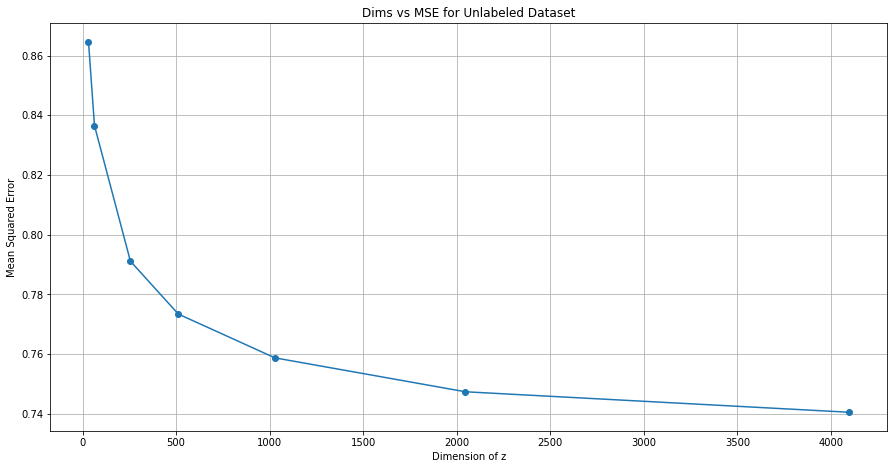

In [21]:
plot_mse(mse_per_dim, dims, "Dims vs MSE for Unlabeled Dataset")

### MSE vs Dims, Test